In [6]:
# -*- coding: utf-8 -*-
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy.linalg import norm
%matplotlib inline

def rgbImg(img):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def grayImg(img):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def getImg(path):
    img = cv2.imread(path)
    if img is None:
        raise RuntimeError('Can not read img from the path.')
    return img


def normalize(img):
    img_back = img.copy()
    cv2.normalize(img, img_back, 0, 255, cv2.NORM_MINMAX)
    return img_back


# 辨識&切下text區塊圖片傳回
def find_text_area(img):
    texts = []
    gray = grayImg(img)
    bl = cv2.medianBlur(gray, 3)
    ret, th = cv2.threshold(bl, 20, 255, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ERODE,(3, 3))
    er1 = cv2.erode(th, kernel, 1)
    zero_cnts = cv2.findNonZero(er1)
    window = np.zeros(th.shape, dtype=np.uint8)
    cv2.drawContours(window, [zero_cnts], 0, (255, 255, 255), 1)
    er_kernel = cv2.getStructuringElement(cv2.MORPH_ERODE, (5, 7))
    er2 = cv2.erode(window, er_kernel, 1)
    di_kernel = cv2.getStructuringElement(cv2.MORPH_DILATE, (5, 7))
    di1 = cv2.dilate(er2, di_kernel, 1)
    cnts2, hierarchy= cv2.findContours(di1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for i, c in enumerate(cnts2):
        min_rect = cv2.minAreaRect(c)
        box = np.int0(cv2.cv.BoxPoints(min_rect))
        rec_sum = box.sum(axis=1)
        point1 = box[np.argmin(rec_sum)]
        point2 = box[np.argmax(rec_sum)]        
        text_img = img[point1[1]+1:point2[1], point1[0]:point2[0]]
        texts.append(text_img)
    return texts[::-1]


# 由text圖片切割字元, 傳回字元list
def seg(text):
    seg_list = []
    um = text[:, 143:, :]
    num_right = text[:, 106:143, :]
    dot = text[:,100: 106, :]
    num_left = text[:, : 100, :]
    
    seg_list.append(um)

    right_length = 143-106
    for i in xrange(0, (143-106)/12):
        seg_img = num_right[:,right_length-12:right_length,:]
        seg_list.append(seg_img)
        right_length = right_length - 12    
    seg_list.append(dot)

    left_length = 100
    for i in xrange(0, 100/12):
        seg_img = num_left[:, left_length-12: left_length, :]
        seg_list.append(seg_img)
        left_length = left_length - 12
    return seg_list


# 以線性內插法修改圖片size
def resize(img, size):
    if not isinstance(img, np.ndarray):
        raise TypeError('Input image type is not numpy.ndarray.')
    elif not isinstance(size, tuple):
        raise TypeError('Input size type is not tuple.')
    elif len(size) > 2 or len(size)< 2:
        raise ValueError('Input size is invalid.')
    return cv2.resize(img, size, interpolation=cv2.INTER_LINEAR)


# 利用sobel邊緣產生hist當成圖片特徵向量
def convert2vector(seg_list):
    data_list = []
    
    for seg_img in seg_list:
        res_img = resize(seg_img,(20,20))
        gray = grayImg(res_img)

        gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1)
        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[: 10, : 10], bin[10: , : 10], bin[: 10, 10:], bin[10:, 10:]
        mag_cells = mag[:10, : 10], mag[10:, : 10], mag[:10, 10:], mag[10:, 10:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)

        eps = 1e-7
        hist /= hist.sum() + eps
        hist = np.sqrt(hist)
        hist /= norm(hist) + eps

        data_list.append(hist)
    dataMat = np.array(data_list, np.float32)
    return dataMat


def prediction(testDataMat):
    # dic = {'11':'blank', '12':'dot', '13':'minus', '14':'um'}
    dic = {'11':'', '12':'.', '13':'-', '14':''}
    result = None
    output = ''
    svm = cv2.SVM()
    svm.load('D:/AOI/OCR_model/OCR_model')
    response = svm.predict_all(testDataMat)
    for i, res in enumerate(response[:: -1]):
        if str(int(res[0])) in dic:
            result = dic[str(int(res[0]))]
        else:
            result = str(int(res))
        output = output + result
    return float(output)


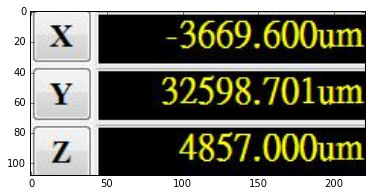

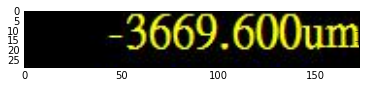

Answer: -3669.6


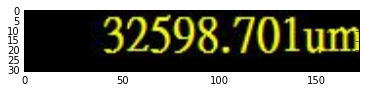

Answer: 32598.701


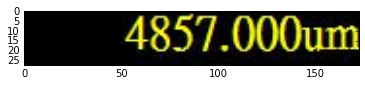

Answer: 4857.0


In [7]:
# example
%prun
img = getImg('D:/AOI/OCR_segments/step2/test_data_03/0016-S2-維修-凹陷-座標.jpg'.decode('utf8').encode('big5'))
plt.imshow(rgbImg(img))
plt.show()
    
texts = find_text_area(img)

for text in texts:
    plt.imshow(rgbImg(text))
    plt.show()
    
    seg_list = seg(text)
    test_data = convert2vector(seg_list)
    result = prediction(test_data)
    print 'Answer:', result

In [9]:
# 批量測試case
# 產生420張截圖的path_list

srcpath = 'D:/AOI/OCR_data/'
path_list = []
for dirPath, dirNames, fileNames in os.walk(srcpath):
    for fname in fileNames:
        src_path = os.path.join(dirPath, fname)
        path_list.append(src_path)
print len(path_list)


420


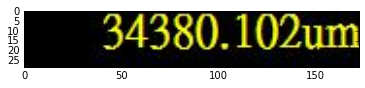

Answer: 34380.102


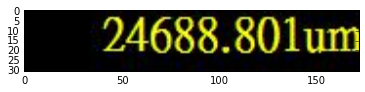

Answer: 24688.801


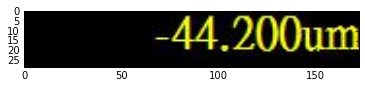

Answer: -44.2


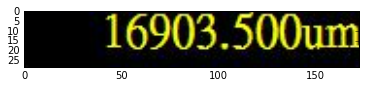

Answer: 16903.5


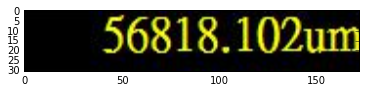

Answer: 56818.102


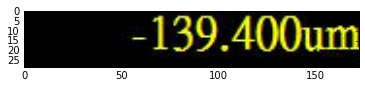

Answer: -139.4


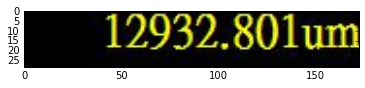

Answer: 12932.801


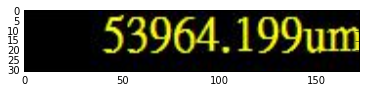

Answer: 53964.199


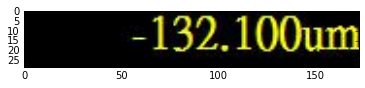

Answer: -132.1


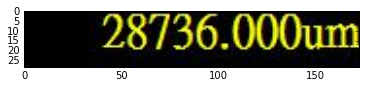

Answer: 28736.0


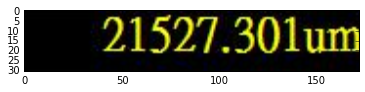

Answer: 21527.301


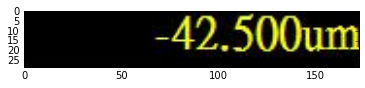

Answer: -42.5


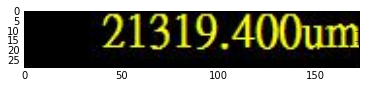

Answer: 21319.4


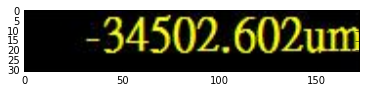

Answer: -34502.602


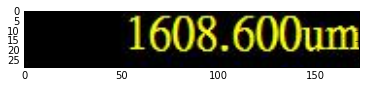

Answer: 1608.6


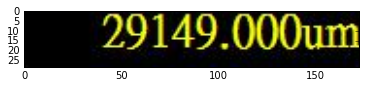

Answer: 29149.0


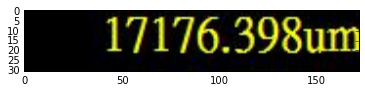

Answer: 17176.398


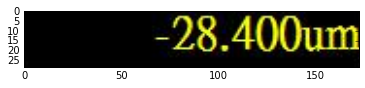

Answer: -28.4


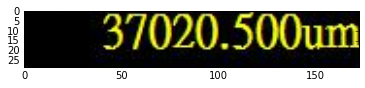

Answer: 37020.5


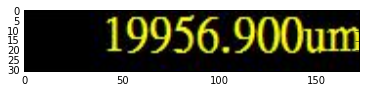

Answer: 19956.9


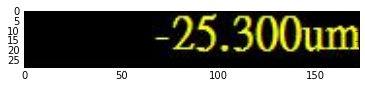

Answer: -25.3


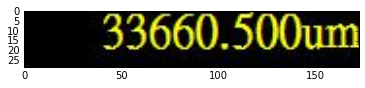

Answer: 33660.5


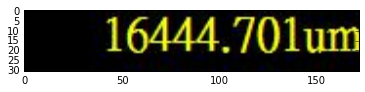

Answer: 16444.701


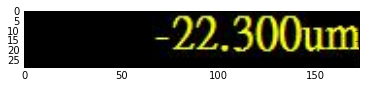

Answer: -22.3


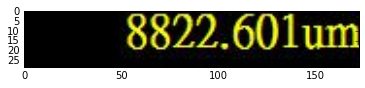

Answer: 8822.601


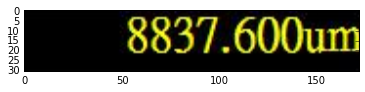

Answer: 8837.6


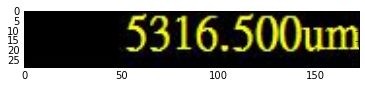

Answer: 5316.5


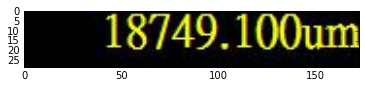

Answer: 18749.1


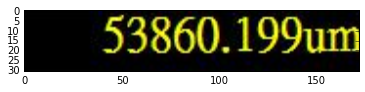

Answer: 53860.199


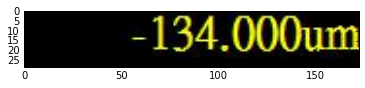

Answer: -134.0


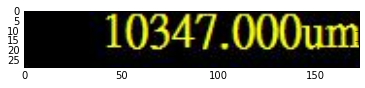

Answer: 10347.0


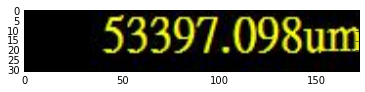

Answer: 53397.098


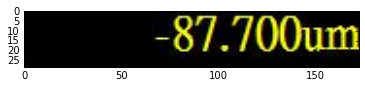

Answer: -87.7


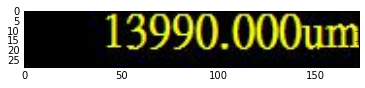

Answer: 13990.0


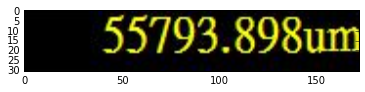

Answer: 55793.898


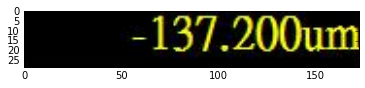

Answer: -137.2


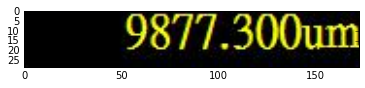

Answer: 9877.3


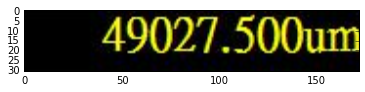

Answer: 49027.5


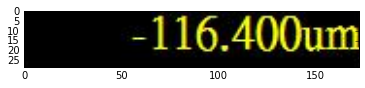

Answer: -116.4


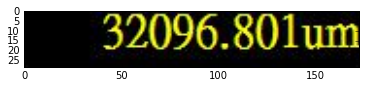

Answer: 32096.801


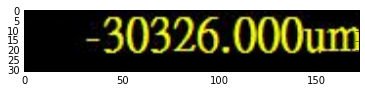

Answer: -30326.0


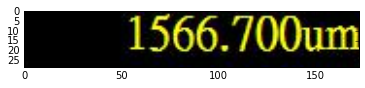

Answer: 1566.7


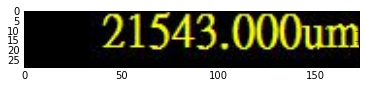

Answer: 21543.0


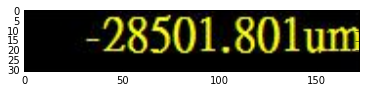

Answer: -28501.801


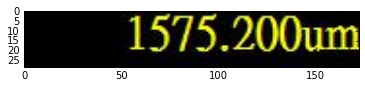

Answer: 1575.2


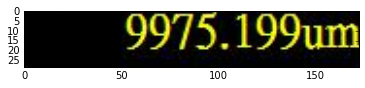

Answer: 9975.199


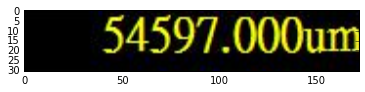

Answer: 54597.0


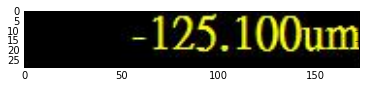

Answer: -125.1


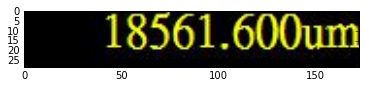

Answer: 18561.6


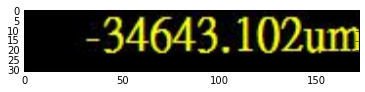

Answer: -34643.102


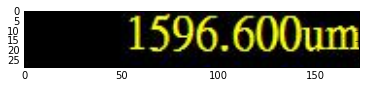

Answer: 1596.6


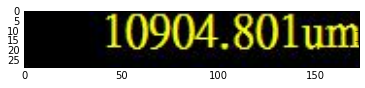

Answer: 10904.801


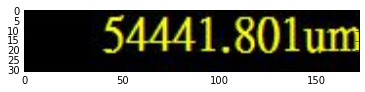

Answer: 54441.801


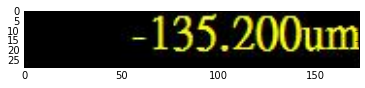

Answer: -135.2


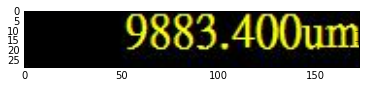

Answer: 9883.4


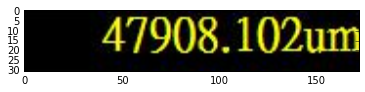

Answer: 47908.102


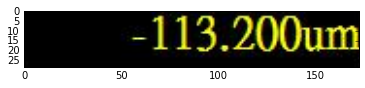

Answer: -113.2


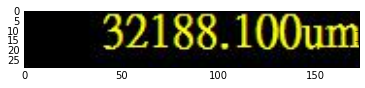

Answer: 32188.1


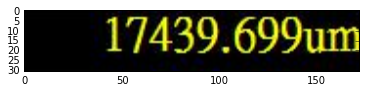

Answer: 17439.699


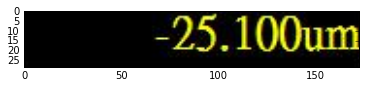

Answer: -25.1


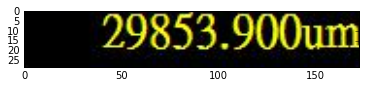

Answer: 29853.9


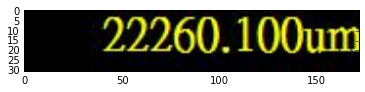

Answer: 22260.1


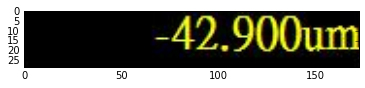

Answer: -42.9


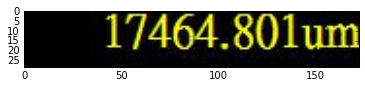

Answer: 17464.801


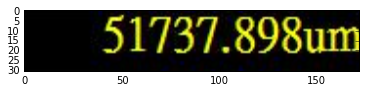

Answer: 51737.898


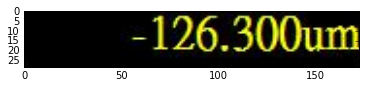

Answer: -126.3


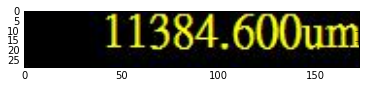

Answer: 11384.6


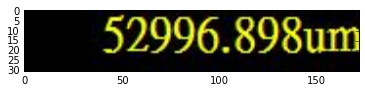

Answer: 52996.898


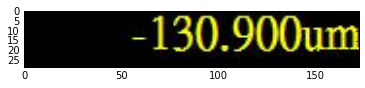

Answer: -130.9


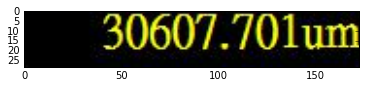

Answer: 30607.701


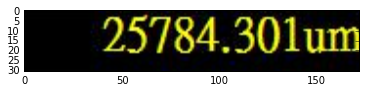

Answer: 25784.301


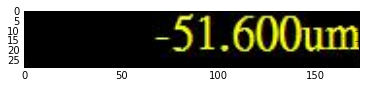

Answer: -51.6


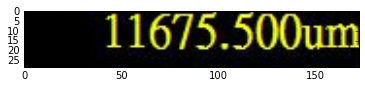

Answer: 11675.5


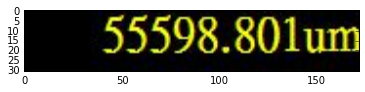

Answer: 55598.801


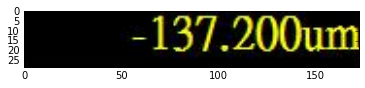

Answer: -137.2


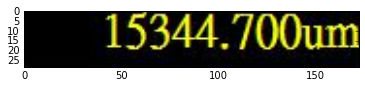

Answer: 15344.7


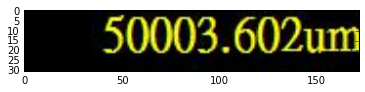

Answer: 50003.602


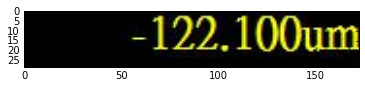

Answer: -122.1


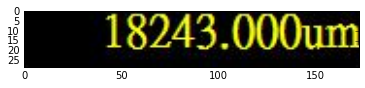

Answer: 18243.0


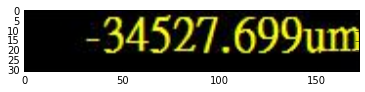

Answer: -34527.699


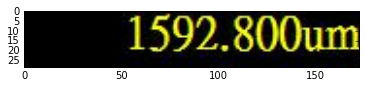

Answer: 1592.8


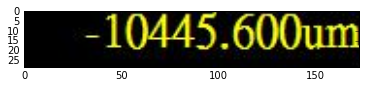

Answer: -10445.6


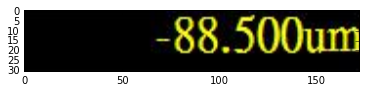

Answer: -88.5


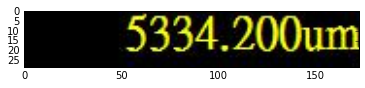

Answer: 5334.2


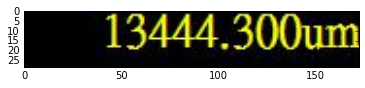

Answer: 13444.3


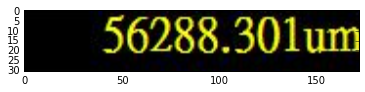

Answer: 56288.301


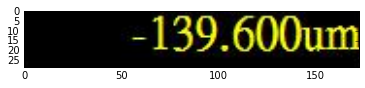

Answer: -139.6


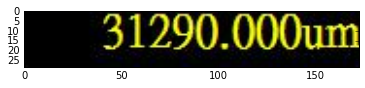

Answer: 31290.0


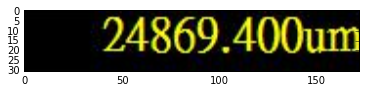

Answer: 24869.4


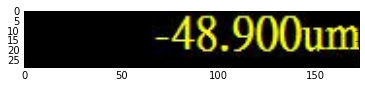

Answer: -48.9


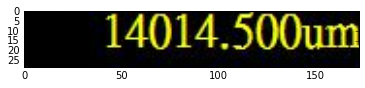

Answer: 14014.5


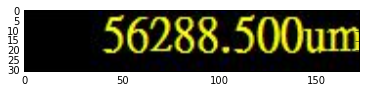

Answer: 56288.5


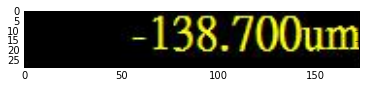

Answer: -138.7


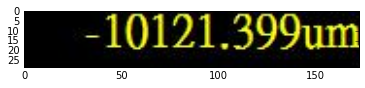

Answer: -10121.399


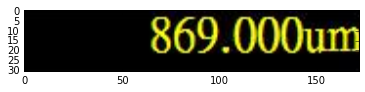

Answer: 869.0


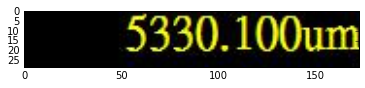

Answer: 5330.1


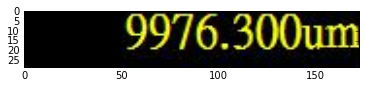

Answer: 9976.3


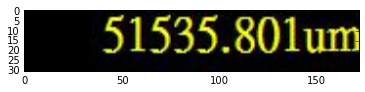

Answer: 51535.801


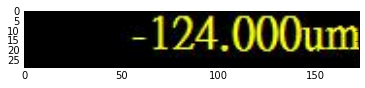

Answer: -124.0


In [10]:
import random

#從path_list隨機抽樣測試, 每張截圖有3個text, 所以k=34會得到34*3個text輸出
samples = random.sample(path_list, k=33)

for path in samples:
    img = getImg(path)
    texts = find_text_area(img)

    for text in texts:
        plt.imshow(rgbImg(text))
        plt.show()

        seg_list = seg(text)
        test_data = convert2vector(seg_list)
        result = prediction(test_data)
        print 'Answer:', result

1